In [3]:
%matplotlib inline
import json
import numpy as np
import glob
import matplotlib.pyplot as plt
import brewer2mpl
import math
import pandas as pd
bmap = brewer2mpl.get_map('Set1', 'qualitative', 9)
colors = bmap.mpl_colors

In [15]:
LOGDIR = '../log/resultsLocal/'
PARAMS = [
## 'ReacherSparse-v1_sarst_future_rnd_2_inf_linear_False_True_0.3',
## 'ReacherSparse-v1_sarst_future_rnd_2_inf_linear_True_True_0.3',
#'ReacherBenchmark-v1_sarst_future_rnd_2_inf_linear_True_False_0.3',
#'ReacherBenchmark-v1_sarst_future_rnd_2_inf_linear_False_False_0.3',
#'ReacherBenchmark-v1_sarst_future_rnd_2_inf_tanh_False_False_0.3',
## 'ReacherSparse-v1_sarst_future_rnd_2_inf_tanh_True_False_0.3',
## 'ReacherSparse-v1_sarst_future_rnd_2_inf_linear_True_False_0.3',
#'ReacherBenchmark-v1_sarst_future_rnd_2_inf_tanh_True_True_0.3',
#'ReacherBenchmark-v1_sarst_future_rnd_2_inf_linear_False_True_0.3',
## 'ReacherSparse-v1_sarst_future_rnd_2_inf_tanh_True_True_0.3',
## 'ReacherSparse-v1_sarst_future_rnd_2_inf_tanh_False_False_0.3',
#'ReacherBenchmark-v1_sarst_future_rnd_2_inf_tanh_False_True_0.3',
#'ReacherBenchmark-v1_sarst_future_rnd_2_inf_linear_True_True_0.3',
#'ReacherBenchmark-v1_sarst_future_rnd_2_inf_tanh_True_False_0.3',
## 'ReacherSparse-v1_sarst_future_rnd_2_inf_tanh_False_True_0.3',
## 'ReacherSparse-v1_sarst_future_rnd_2_inf_linear_False_False_0.3'
    
# 'HalfCheetah-v1_sarst_future_rnd_2_inf_linear_False_False_0.3',
# 'HalfCheetah-v1_sarst_future_rnd_2_inf_tanh_False_True_0.3',
# 'HalfCheetah-v1_sarst_future_rnd_2_inf_tanh_True_False_0.5',
# 'HalfCheetah-v1_sarst_future_rnd_2_inf_tanh_False_False_0.5',
# 'HalfCheetah-v1_sarst_future_rnd_2_inf_tanh_True_False_0.3',
# 'HalfCheetah-v1_sarst_future_rnd_2_inf_linear_True_False_0.5',
# 'HalfCheetah-v1_sarst_future_rnd_2_inf_linear_True_True_0.5',
# 'HalfCheetah-v1_sarst_future_rnd_2_inf_linear_True_False_0.3',
# 'HalfCheetah-v1_sarst_future_rnd_2_inf_tanh_True_True_0.3',
# 'HalfCheetah-v1_sarst_future_rnd_2_inf_linear_False_False_0.5',
# 'HalfCheetah-v1_sarst_future_rnd_2_inf_linear_False_True_0.3',
# 'HalfCheetah-v1_sarst_future_rnd_2_inf_tanh_False_True_0.5',
# 'HalfCheetah-v1_sarst_future_rnd_2_inf_linear_False_True_0.5',
# 'HalfCheetah-v1_sarst_future_rnd_2_inf_tanh_False_False_0.3',
# 'HalfCheetah-v1_sarst_future_rnd_2_inf_tanh_True_True_0.5',
# 'HalfCheetah-v1_sarst_future_rnd_2_inf_linear_True_True_0.3',
'CMCPos-v0_sarst_final_rnd_0.1_inf_tanh_True_True_2'    
]

In [16]:
frames = [] # List of pandas dataframes corresponding to each results file
for PARAM in PARAMS:
    # Fetching json files corresponding to one set of parameters
    res_steps = glob.glob(LOGDIR + PARAM + '/*/' + 'log_steps/progress.json') 
    for num_run, run in enumerate(res_steps):
        # Discarding runs with broken result files
        try:
            df = pd.read_json(run, lines=True)
        except ValueError:
            print("run "+run+": invalid")
        df['params'] = PARAM
        df['num_run']=num_run
        frames.append(df)
# Creating the complete dataframe with all dat
expe_res_steps = pd.concat(frames, ignore_index=True)
expe_res_steps

,Test reward on initial goal,Test reward on random goal,action_grads,mean_Q_values,training_step,params,num_run
0,-0.785441,-0.580129,0.034315,-0.060891,100,CMCPos-v0_sarst_final_rnd_0.1_inf_tanh_True_Tr...,0
1,-4.329638,48.370736,0.082750,-0.076374,200,CMCPos-v0_sarst_final_rnd_0.1_inf_tanh_True_Tr...,0
2,-13.909644,-15.021392,0.126107,0.112646,300,CMCPos-v0_sarst_final_rnd_0.1_inf_tanh_True_Tr...,0
3,-35.461323,-25.530020,0.280156,0.154735,400,CMCPos-v0_sarst_final_rnd_0.1_inf_tanh_True_Tr...,0
4,-49.960401,-50.025569,0.219640,0.204941,500,CMCPos-v0_sarst_final_rnd_0.1_inf_tanh_True_Tr...,0
5,-56.526129,-71.487378,0.112778,0.147153,600,CMCPos-v0_sarst_final_rnd_0.1_inf_tanh_True_Tr...,0
6,-63.863296,-55.007643,0.146656,0.170661,700,CMCPos-v0_sarst_final_rnd_0.1_inf_tanh_True_Tr...,0
7,-69.221991,-63.039722,0.128256,0.136027,800,CMCPos-v0_sarst_final_rnd_0.1_inf_tanh_True_Tr...,0
8,-72.506039,-62.086922,0.107877,0.112422,900,CMCPos-v0_sarst_final_rnd_0.1_inf_tanh_True_Tr...,0
9,-75.801652,-63.344684,0.091500,0.130195,1000,CMCPos-v0_sarst_final_rnd_0.1_inf_tanh_True_Tr...,0


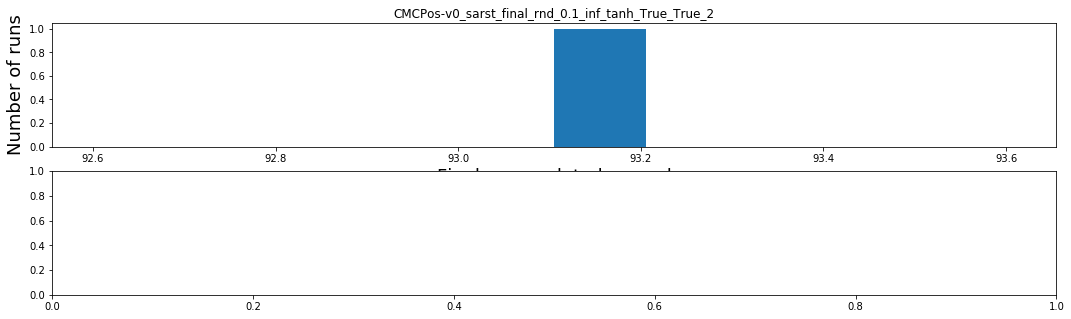

In [17]:
# Only keeping lines corresponding to the evaluation at training step N
N = 100000
res_final = expe_res_steps[expe_res_steps['training_step']==N]

# For each set of parameters, plot the histogram of performances on the initial goal at step N over the different runs
fig, axes = plt.subplots(2,1, figsize=(18,5))
for i,(name, g) in enumerate(res_final.groupby('params')['Test reward on initial goal']):
    axes[i].hist(g)
    axes[i].set_title(name)
    axes[i].set_xlabel('Final accumulated reward', fontsize=18)
    axes[i].set_ylabel('Number of runs', fontsize=18)


CMCPos-v0_sarst_final_rnd_0.1_inf_tanh_True_True_2 [0]


(-5000, 200000)

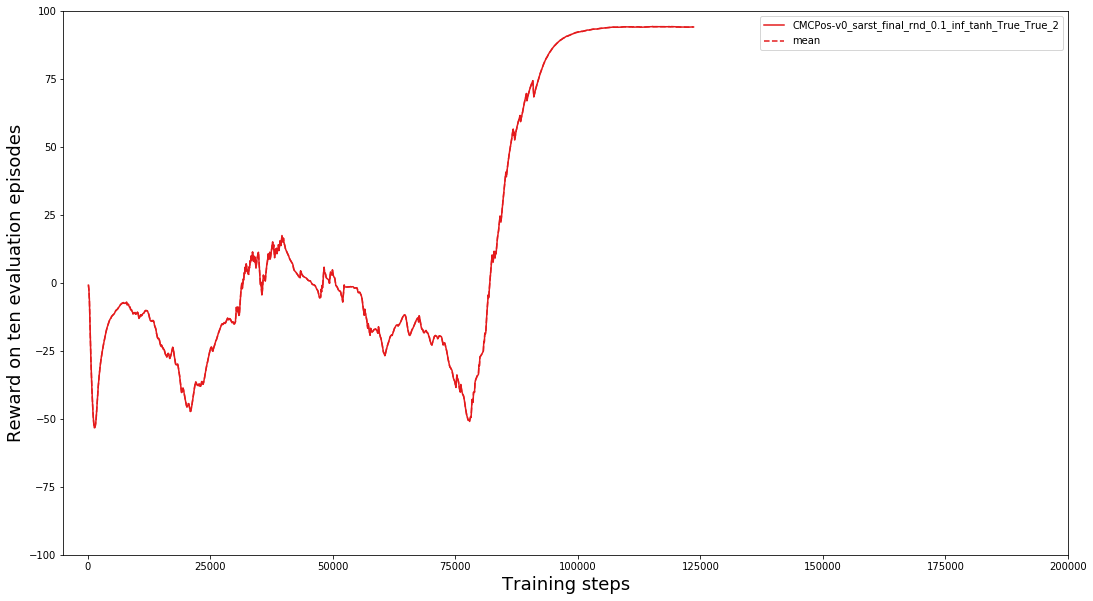

In [21]:
# Retrieve for each set of parameters the list of runs with final performance over a given threshold. 
# Can be adapted to filter on different things
# Store these runs numbers in a dictionary
dico = {}
for name, g in expe_res_steps[expe_res_steps['training_step']==100000].groupby('params'):
#     dico[name] = list(g[g['Test reward on initial goal']>-100]['num_run'].values)
    dico[name] = list(g['num_run'].values)
    print(name, dico[name])
    
# From the dictionary, compute a boolean dataframe, with True at index i if the data at index i of the result dataframe
# matches the filter. Apply this boolean mask to the results dataframe to retrieve the filtered data
def in_dico(g):
    res = g['num_run'] in dico[g['params']]
    res = (g['num_run'] in [0,1,2,4])
    return res
mask = expe_res_steps.apply(in_dico, axis=1)
filtered = expe_res_steps[mask]
# filtered = expe_res_steps

# Define the functions for the statistics we want to compute on the dataframe
def quant_inf(x) : return x.quantile(0.1)
def quant_sup(x) : return x.quantile(0.9)
op_dict = {'Test reward on initial goal':[np.mean, np.median, quant_inf,quant_sup]}
columns = ['Test reward on initial goal','training_step','params']

# Apply these functions to the dataframe and store the results in additional columns
stats_eval_init = filtered[columns].groupby(['training_step','params']).agg(op_dict).reset_index()

# Exponentional smoothing of the curve. Increase the ewm parameter for more smoothing.
stats_eval_init_smooth = stats_eval_init[['params','Test reward on initial goal']].groupby('params').apply(lambda x: x.ewm(30).mean())

# Weird bug I had, where the word training caused problems 
stats_eval_init_smooth['trainin_step']=stats_eval_init['training_step']

# Plot the statistics for the results of each set of parameters
fig, ax = plt.subplots(figsize=(18,10))
for i, (name, g) in enumerate(stats_eval_init_smooth.groupby(['params'])):
    if name in PARAMS:
        params = name.split('_')
#         ax.plot(g['trainin_step'], g['Test reward on initial goal']['mean'], label=name)
        ax.plot(g['trainin_step'], g['Test reward on initial goal']['median'], label=name, color=colors[i])
        ax.plot(g['trainin_step'], g['Test reward on initial goal']['mean'], color=colors[i], linestyle='dashed')
        ax.fill_between(g['trainin_step'], 
                        g['Test reward on initial goal']['quant_inf'], 
                        g['Test reward on initial goal']['quant_sup'], alpha=0.25, linewidth=0, color=colors[i])
ax.legend()
ax.set_xlabel('Training steps', fontsize=18)
ax.set_ylabel('Reward on ten evaluation episodes', fontsize=18)
ax.set_ylim([-100,100])
ax.set_xlim([-5000,200000])


CMCPos-v0_sarst_final_rnd_0.1_inf_tanh_True_True_2 [0]


(0, 200000)

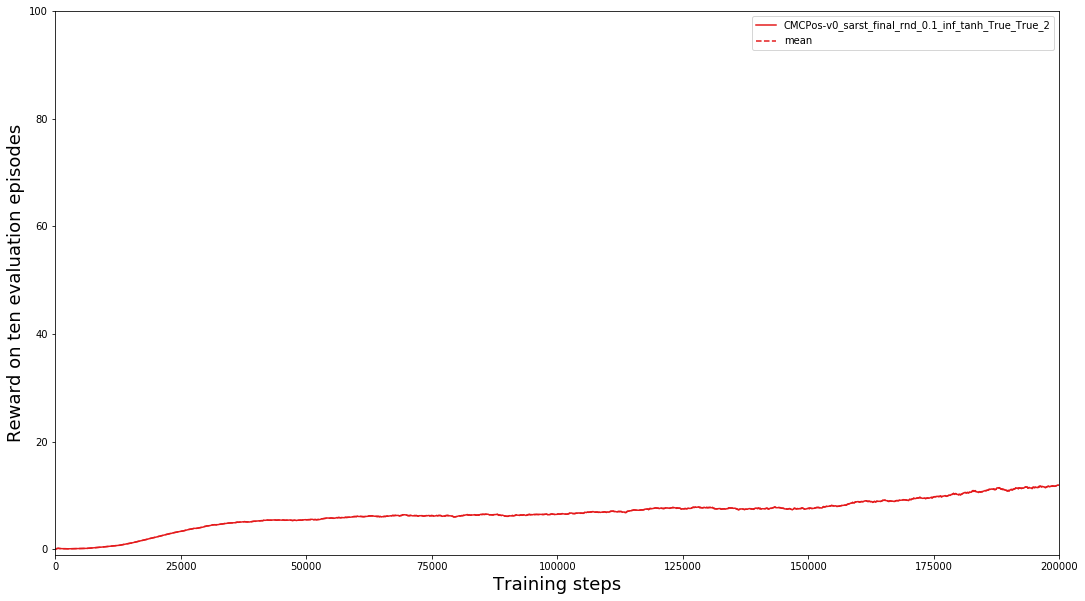

In [14]:
# Retrieve for each set of parameters the list of runs with final performance over a given threshold. 
# Can be adapted to filter on different things
# Store these runs numbers in a dictionary
dico = {}
for name, g in expe_res_steps[expe_res_steps['training_step']==190000].groupby('params'):
#     dico[name] = list(g[g['Test reward on initial goal']>-100]['num_run'].values)
    dico[name] = list(g['num_run'].values)
    print(name, dico[name])
    
# From the dictionary, compute a boolean dataframe, with True at index i if the data at index i of the result dataframe
# matches the filter. Apply this boolean mask to the results dataframe to retrieve the filtered data
def in_dico(g):
    res = g['num_run'] in dico[g['params']]
#     res = (g['num_run'] in [0,1,2,4])
    return res
mask = expe_res_steps.apply(in_dico, axis=1)
filtered = expe_res_steps[mask]
# filtered = expe_res_steps

grandeur = 'action_grads'

# Define the functions for the statistics we want to compute on the dataframe
def quant_inf(x) : return x.quantile(0.1)
def quant_sup(x) : return x.quantile(0.9)
op_dict = {grandeur:[np.mean, np.median, quant_inf,quant_sup]}
columns = [grandeur,'training_step','params']

# Apply these functions to the dataframe and store the results in additional columns
stats_eval_init = filtered[columns].groupby(['training_step','params']).agg(op_dict).reset_index()

# Exponentional smoothing of the curve. Increase the ewm parameter for more smoothing.
stats_eval_init_smooth = stats_eval_init[['params',grandeur]].groupby('params').apply(lambda x: x.ewm(30).mean())

# Weird bug I had, where the word training caused problems 
stats_eval_init_smooth['trainin_step']=stats_eval_init['training_step']

# Plot the statistics for the results of each set of parameters
fig, ax = plt.subplots(figsize=(18,10))
for i, (name, g) in enumerate(stats_eval_init_smooth.groupby(['params'])):
    if name in PARAMS:
        params = name.split('_')
#         ax.plot(g['trainin_step'], g['Test reward on initial goal']['mean'], label=name)
        ax.plot(g['trainin_step'], g[grandeur]['median'], label=name, color=colors[i])
        ax.plot(g['trainin_step'], g[grandeur]['mean'], color=colors[i], linestyle='dashed')
        ax.fill_between(g['trainin_step'], 
                        g[grandeur]['quant_inf'], 
                        g[grandeur]['quant_sup'], alpha=0.25, linewidth=0, color=colors[i])
ax.legend()
ax.set_xlabel('Training steps', fontsize=18)
ax.set_ylabel('Reward on ten evaluation episodes', fontsize=18)
ax.set_ylim([-1,100])
ax.set_xlim([0,200000])


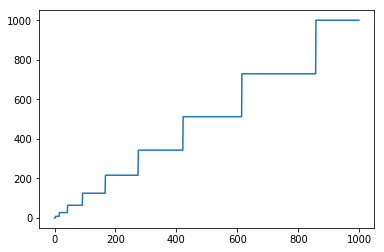

In [25]:
x = range(1000)
y = [int(round(a ** (1/3)) ** 3) for a in x]
plt.plot(x,y)

<a list of 34 Text yticklabel objects>


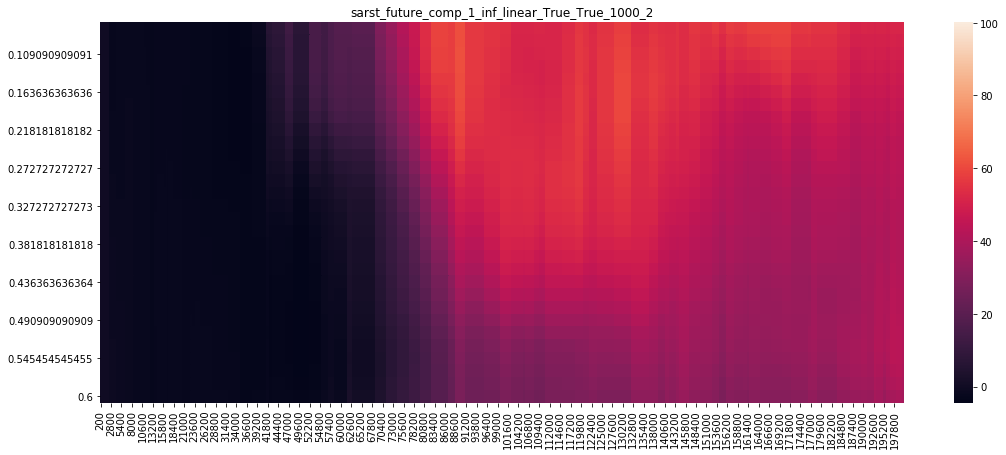

In [51]:
import seaborn as sns
fig, axes = plt.subplots(len(PARAMS), figsize=(18,7))
expe_res_steps_0 = expe_res_steps[(expe_res_steps['num_run']==0)]
# expe_res_steps_0 = expe_res_steps[(expe_res_steps['num_run']==0) & (expe_res_steps['training_step']<=70000)]
for i, (name, g) in enumerate(expe_res_steps_0.groupby('params')):
    q_vals = g['q_values'].apply(pd.Series)
    heatmap = q_vals.T
    heatmap.columns = range(200, 200001,200)
#     heatmap.columns = range(200, 70001,200)
    sns.heatmap(heatmap, ax=axes)
    axes.set_title(name)
    print(axes.get_yticklabels())
    axes.set_ylim([100,70])
    axes.set_yticklabels([list(np.linspace(-1.2, 0.6, 100))[int(label.get_text())] for label in axes.get_yticklabels()])

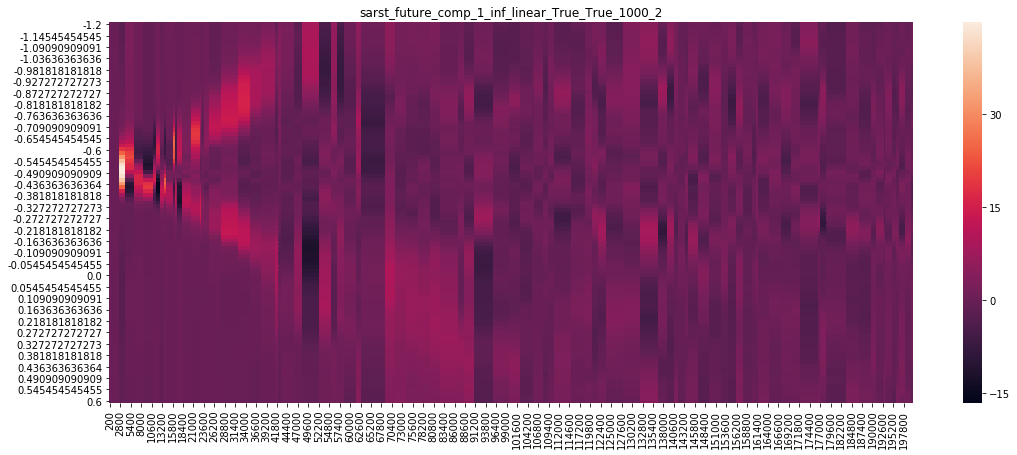

In [42]:
import seaborn as sns
fig, axes = plt.subplots(len(PARAMS), figsize=(18,7))
expe_res_steps_0 = expe_res_steps[(expe_res_steps['num_run']==0)]
# expe_res_steps_0 = expe_res_steps[(expe_res_steps['num_run']==0) & (expe_res_steps['training_step']<=70000)]
for i, (name, g) in enumerate(expe_res_steps_0.groupby('params')):
    q_vals = g['d_q_values'].apply(pd.Series)
    heatmap = q_vals.T
    heatmap.columns = range(200, 200001,200)
#     heatmap.columns = range(200, 70001,200)
    sns.heatmap(heatmap, ax=axes)
    axes.set_title(name)
    axes.set_yticklabels([list(np.linspace(-1.2, 0.6, 100))[int(label.get_text())] for label in axes.get_yticklabels()])
#     axes.set_xlim([0,70000])

In [43]:
frames = []
for PARAM in PARAMS:
    param_vals = PARAM.split('_')
    res_episodes = glob.glob(LOGDIR + PARAM + '/*/' + 'log_episodes/progress.json')
    for num_run, run in enumerate(res_episodes):
        try:
            df = pd.read_json(run, lines=True)
        except ValueError:
            print("run "+run+": invalid")
        df['params'] = PARAM
        df['num_run']=num_run
        frames.append(df)
expe_res_episodes = pd.concat(frames, ignore_index=True)
expe_res_episodes

,Duration,Episode,Episode steps,Final_state,Goal,Goal reached,Start,Train reward,Train step,params,num_run
0,0.215156,1,35,-0.207075,-0.218182,1,-0.481433,97.295769,35,sarst_future_comp_1_inf_linear_True_True_1000_2,0
1,0.514785,2,101,-0.123212,-0.145455,2,-0.456615,92.479165,136,sarst_future_comp_1_inf_linear_True_True_1000_2,0
2,0.544616,3,17,-0.338596,-0.345455,3,-0.597645,98.300000,153,sarst_future_comp_1_inf_linear_True_True_1000_2,0
3,10.886660,4,152,-1.057473,-1.036364,4,-0.443859,87.743435,305,sarst_future_comp_1_inf_linear_True_True_1000_2,0
4,11.879921,5,13,-0.633381,-0.618182,5,-0.492799,98.700000,318,sarst_future_comp_1_inf_linear_True_True_1000_2,0
5,22.346054,6,157,-0.307330,-0.345455,6,-0.443837,86.858679,475,sarst_future_comp_1_inf_linear_True_True_1000_2,0
6,116.192528,7,1000,-0.578187,0.545455,6,-0.502574,-96.510592,1475,sarst_future_comp_1_inf_linear_True_True_1000_2,0
7,212.826460,8,1000,-0.399769,-0.672727,6,-0.480715,-100.000000,2475,sarst_future_comp_1_inf_linear_True_True_1000_2,0
8,215.112139,9,40,0.037898,0.036364,7,-0.583453,96.000000,2515,sarst_future_comp_1_inf_linear_True_True_1000_2,0
9,217.643441,10,40,0.055156,0.054545,8,-0.594253,96.000000,2555,sarst_future_comp_1_inf_linear_True_True_1000_2,0


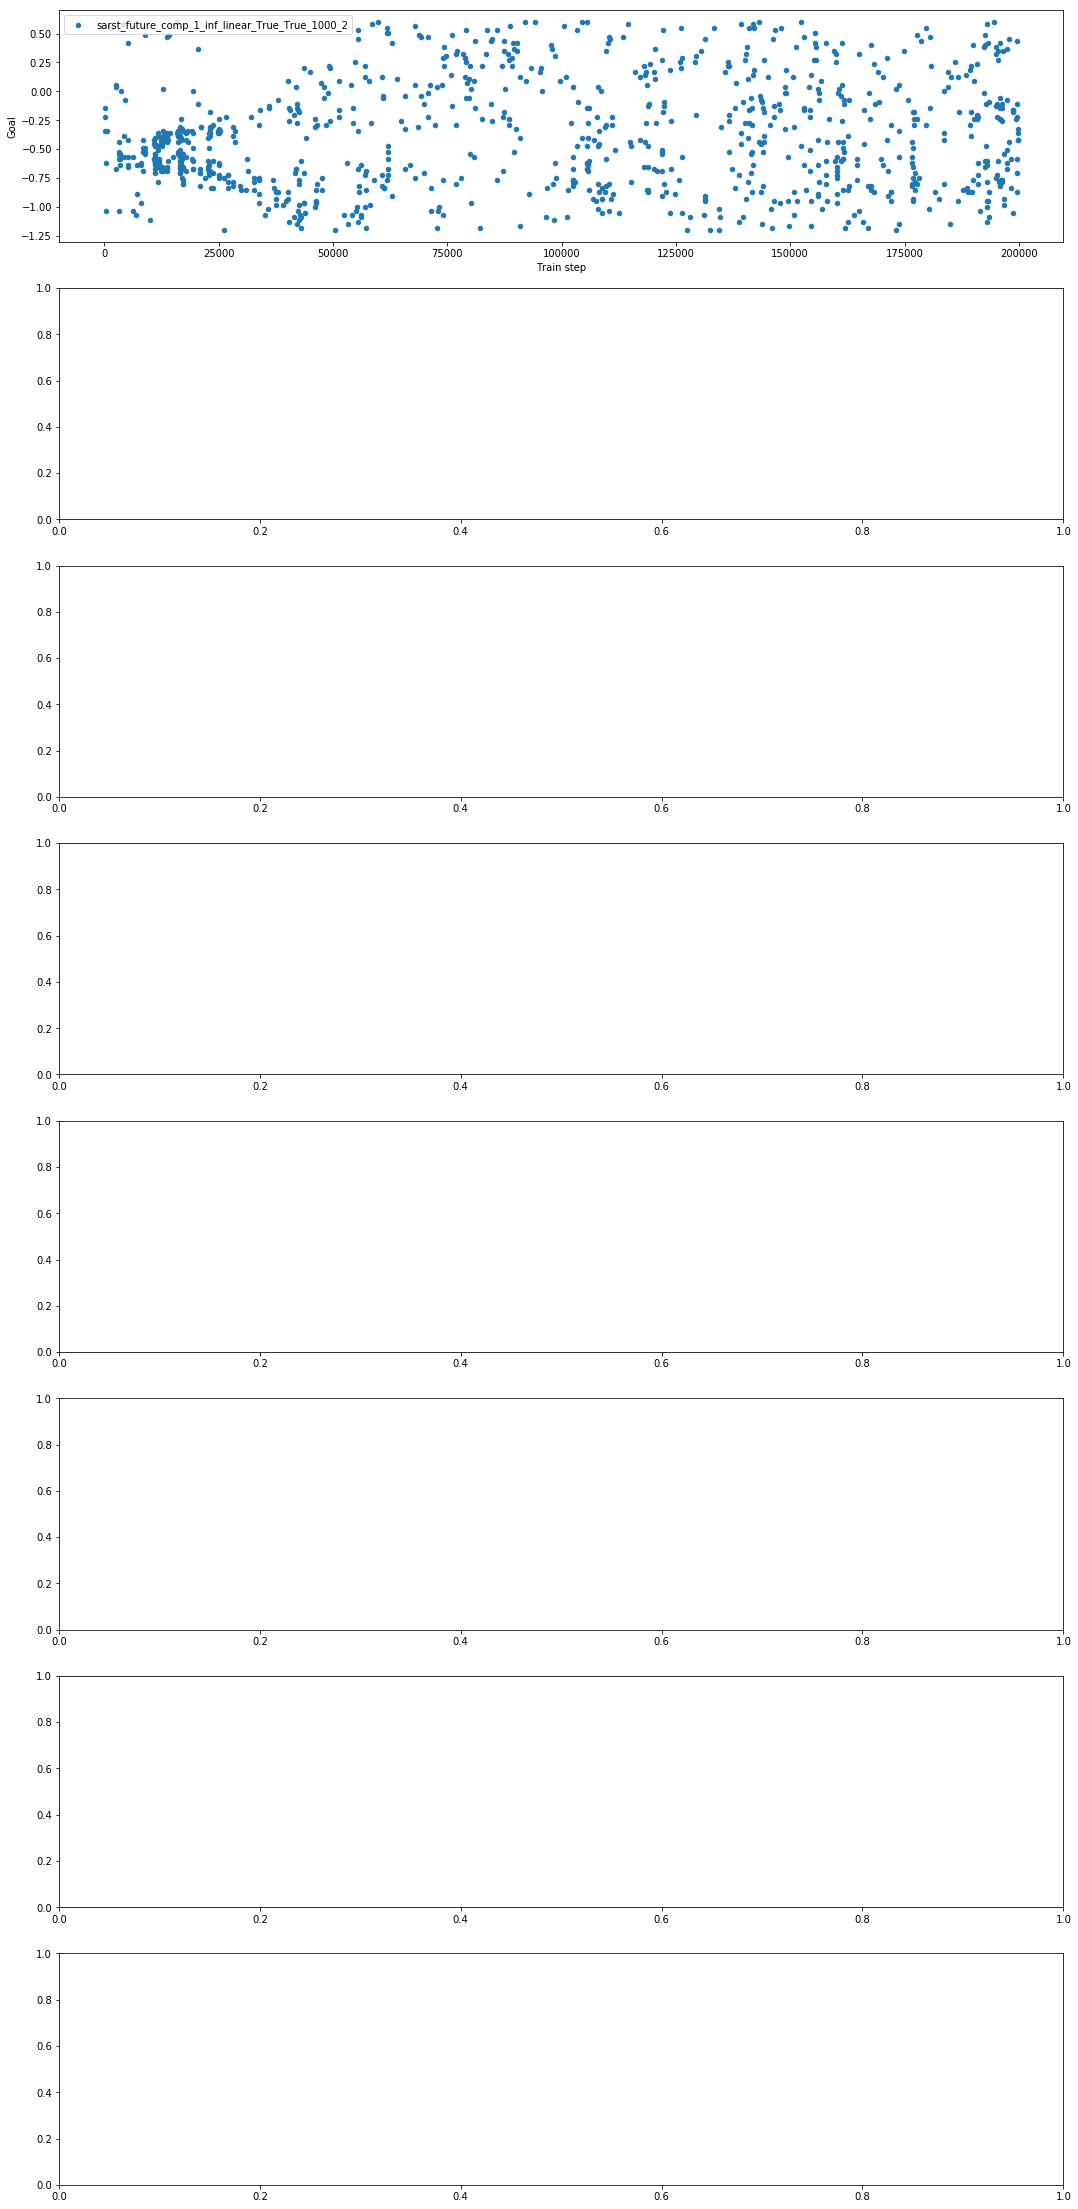

In [44]:
expe_res_ep_plot = expe_res_episodes[expe_res_episodes['num_run']==0]
fig, axes = plt.subplots(8, figsize=(18,40))
for i, (name, g) in enumerate(expe_res_ep_plot.groupby('params')):
    g.plot(x='Train step', y='Goal', label=name, ax=axes[i], kind='scatter')